In [1]:
library(scRNAseq)
sce.zeisel <- ZeiselBrainData()

library(scater)
sce.zeisel <- aggregateAcrossFeatures(sce.zeisel, 
    id=sub("_loc[0-9]+$", "", rownames(sce.zeisel)))

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [2]:
sce.zeisel

class: SingleCellExperiment 
dim: 19839 3005 
metadata(0):
assays(1): counts
rownames(19839): 0610005C13Rik 0610007N19Rik ... Zzef1 Zzz3
rowData names(1): featureType
colnames(3005): 1772071015_C02 1772071017_G12 ... 1772066098_A12
  1772058148_F03
colData names(10): tissue group # ... level1class level2class
reducedDimNames(0):
mainExpName: endogenous
altExpNames(2): ERCC repeat

#  Library size normalization

Library size normalization is the simplest strategy for performing scaling normalization. We define the library size as the total sum of counts across all genes for each cell, the expected value of which is assumed to scale with any cell-specific biases. The “library size factor” for each cell is then directly proportional to its library size where the proportionality constant is defined such that the mean size factor across all cells is equal to 1. This definition ensures that the normalized expression values are on the same scale as the original counts, which is useful for interpretation - especially when dealing with transformed data (see Section 2.5).

In [3]:
library(scater)
lib.sf.zeisel <- librarySizeFactors(sce.zeisel)
summary(lib.sf.zeisel)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1721  0.5437  0.8635  1.0000  1.2895  4.2466 

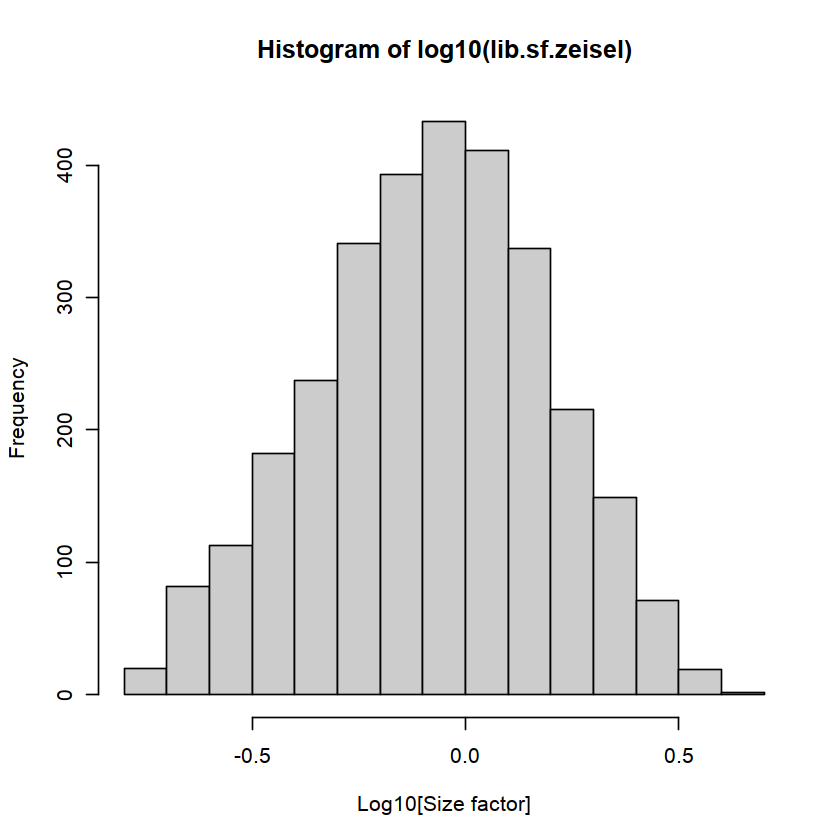

In [4]:
hist(log10(lib.sf.zeisel), xlab="Log10[Size factor]", col='grey80')

# Normalization by deconvolution

single-cell data can be problematic for these bulk normalization methods due to the dominance of low and zero counts. To overcome this, we pool counts from many cells to increase the size of the counts for accurate size factor estimation (Lun, Bach, and Marioni 2016). Pool-based size factors are then “deconvolved” into cell-based factors for normalization of each cell’s expression profile. This is performed using the calculateSumFactors() function from scran, as shown below.

In [5]:
library(scran)
set.seed(100)
clust.zeisel <- quickCluster(sce.zeisel) 
table(clust.zeisel)

clust.zeisel
  1   2   3   4   5   6   7   8   9  10  11  12  13  14 
242 251 153 229 164 226 399 132 264 292 176 205 108 164 

In [6]:
deconv.sf.zeisel <- calculateSumFactors(sce.zeisel, cluster=clust.zeisel)
summary(deconv.sf.zeisel)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1156  0.4497  0.8126  1.0000  1.3357  4.8941 

We use a pre-clustering step with `quickCluster()` where cells in each cluster are normalized separately and the size factors are rescaled to be comparable across clusters. This avoids the assumption that most genes are non-DE across the entire population - only a non-DE majority is required between pairs of clusters, which is a weaker assumption for highly heterogeneous populations. By default, `quickCluster()` will use an approximate algorithm for PCA based on methods from the irlba package. The approximation relies on stochastic initialization so we need to set the random seed (via `set.seed()`) for reproducibility.


We see that the deconvolution size factors exhibit cell type-specific deviations from the library size factors in Figure 2.2. This is consistent with the presence of composition biases that are introduced by strong differential expression between cell types. Use of the deconvolution size factors adjusts for these biases to improve normalization accuracy for downstream applications.

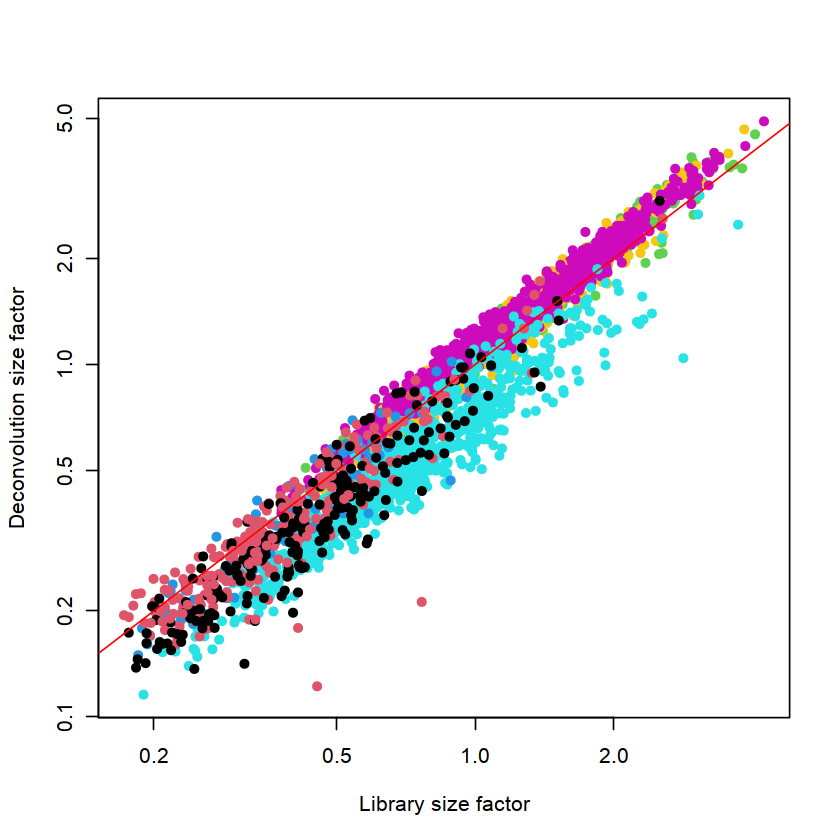

In [21]:
plot(lib.sf.zeisel, deconv.sf.zeisel, xlab="Library size factor",
    ylab="Deconvolution size factor", log='xy', pch=16,
    col=as.integer(factor(sce.zeisel$level1class)))
abline(a=0, b=1, col="red")

# Scaling and log-transforming

Once we have computed the size factors, we use the `logNormCounts()` function from scater to compute normalized expression values for each cell. This is done by dividing the count for each gene/spike-in transcript with the appropriate size factor for that cell. The function also log-transforms the normalized values, creating a new assay called "`logcounts`". (Technically, these are “log-transformed normalized expression values”, but that’s too much of a mouthful to fit into the assay name.) These log-values will be the basis of our downstream analyses in the following chapters.

In [22]:
set.seed(100)
clust.zeisel <- quickCluster(sce.zeisel) 
sce.zeisel <- computeSumFactors(sce.zeisel, cluster=clust.zeisel, min.mean=0.1)
sce.zeisel <- logNormCounts(sce.zeisel)
assayNames(sce.zeisel)

[1] "counts"    "logcounts"